# K-nearest neighbors and scikit-learn

## Agenda

1. Review of the iris dataset and Human learning 
3. K-nearest neighbors (KNN) classification - Intution
4. Review of supervised learning
5. About scikit-learn: Pros and Cons
6. Requirements for working with data in scikit-learn
7. scikit-learn: 4-step modeling pattern, try KNN with sklearn
8. Tuning a KNN model
9. Comparing KNN with other models

## Lesson goals
1. Learn how KNN works (initutively)
2. Learn how the modeling process works
3. Learn how to use scikit-learn models
4. Use scikit learn to build a KNN classifier

## Review of the iris dataset

In [1]:
# read the iris data into a DataFrame
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [2]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Terminology

- **150 observations** (n=150): each observation is one iris flower
- **4 features** (p=4): sepal length, sepal width, petal length, and petal width
- **Response**: iris species
- **Classification problem** since response is categorical

## Human learning 

How did we (as humans) predict the species of an iris?

1. We observed that the different species had (somewhat) dissimilar measurements.
2. We focused on features that seemed to correlate with the response.
3. We created a set of rules (using those features) to predict the species of an unknown iris.

We assumed that if an **unknown iris** has measurements similar to **previous irises**, then its species is most likely the same as those previous irises.

## K Nearest Neighbors
** Developing some intuition **

Our first machine learning method for classification is called K Nearest Neighbors(KNN). This method is based on some very straightforward ideas and intuition, so we're going start by developing some KNN-like ideas by ourselves, from scratch. Once we have a good intution, we'll turn over to the awesome Python library *scikit-learn*, which houses many machine learning methods, and which we'll be using constantly for the rest of the course.

In [3]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14



In [4]:
# map each iris species to a number
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

Let's take another look at the iris dataset, this time focusing on just two of the columns. We'll make a scatterplot of all the datapoints and we'll color each point according to which species it is. 

In [5]:
iris_subset = iris[["petal_length","petal_width","species_num"]]

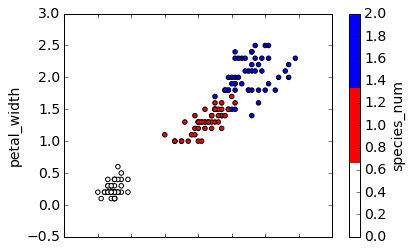

In [8]:
# create a custom color scale
col_map = colors.ListedColormap(['white', 'red',"blue"])

# create a scatter plot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris_subset.plot(kind="scatter",x="petal_length",y="petal_width",c="species_num",cmap=col_map)

We see some of the same basic patterns we observed before - the different species tend to be similar in their *petal width* and *petal height*. That is, all the data points of one species tend to have *petal height* with are more similar to each other than to those of the other two species.

So what if we encounter some new flower that we don't know about? We measure its petal height and width and we add it to the plot below as the blue "x". 

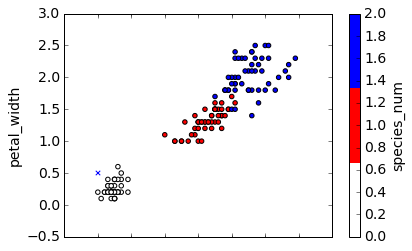

In [9]:
iris_subset.plot(kind="scatter",x="petal_length",y="petal_width",c="species_num",cmap=col_map)
plt.scatter(1,.5,marker='x')

We don't know the *true* species for this new data point, but what might we guess? And why?

Our unknown point is *pretty similar* to the other data points that have species **0**, so that seems like a good guess. And by *pretty similar*, we probably mean *close to*, as in *distance*. This simple idea is what KNN is all about. Whoever my *closest neighbors* are, there's a pretty good bet that I'm of the same type as them.

**Exercise 1 - Going the Distance **

Write a function called *distance* that takes in two "datapoints" (DataFrame rows, or lists representing coordinate pairs) and calculates and returns the distance between them.

In [12]:
def distance(pointA,pointB):
    d= ((pointA[0]-pointB[0])**2+(pointA[1]-pointB[1])**2)**(0.5)
    return d

In [13]:
distance(iris_subset.iloc[0],iris_subset.iloc[100])

5.1429563482495162

In [14]:
distance(iris_subset.iloc[0],iris_subset.iloc[0])

0.0

** Exercise 2 - Everybody Now **

Write a function *calc_all_distances* that takes in two inputs - a single reference data point, and an entire data frame. This function will calculate the distance between every row in the data frame and the reference data point. This function will return a new DataFrame that is a copy of the input DataFrame but with an additional column called *distance_to_reference*.

In [15]:
def calc_all_distances(referencePoint, df):
    new_df = df.copy()
    new_df['distance_to_reference'] = distance(referencePoint,[df.petal_length, df.petal_width])
    return new_df

In [16]:
calc_all_distances([6.2,2.0],iris_subset).sort_values("distance_to_reference").head(5)

,petal_length,petal_width,species_num,distance_to_reference
130,6.1,1.9,2,0.141421
131,6.4,2.0,2,0.200000
107,6.3,1.8,2,0.223607
125,6.0,1.8,2,0.282843
102,5.9,2.1,2,0.316228


So for a given data point of interest, we can find its absolute closest neighbor:

In [16]:
calc_all_distances([6.2,2.0],iris_subset).sort_values("distance_to_reference").head(1)

,petal_length,petal_width,species_num,distance_to_reference
130,6.1,1.9,2,0.141421


Or, we can find its top 10 closest neighbors:

In [17]:
calc_all_distances([6.2,2.0],iris_subset).sort_values("distance_to_reference").head(10)

,petal_length,petal_width,species_num,distance_to_reference
130,6.1,1.9,2,0.141421
131,6.4,2.0,2,0.200000
107,6.3,1.8,2,0.223607
125,6.0,1.8,2,0.282843
102,5.9,2.1,2,0.316228
135,6.1,2.3,2,0.316228
105,6.6,2.1,2,0.412311
143,5.9,2.3,2,0.424264
108,5.8,1.8,2,0.447214
104,5.8,2.2,2,0.447214


And from those close neighbors, we can see which species **they** are, and that's a pretty good guess about which species our data point of interest is.

And that basic idea is how KNN works. Later, we'll try this with scikit-learn and then spend some time learning about scikit-learn workflows and interfaces.

## K-nearest neighbors (KNN) classification

1. Pick a value for K.
2. Search for the K observations in the data that are "nearest" to the measurements of the unknown iris.
    - Euclidian distance is often used as the distance metric, but other metrics are allowed.
3. Use the most popular response value from the K "nearest neighbors" as the predicted response value for the unknown iris.

What is the effect of changing K? How does small K versus large K change things?

### KNN classification map for iris (K=1)

![1NN classification map](images/iris_01nn_map.png)

### KNN classification map for iris (K=5)

![5NN classification map](images/iris_05nn_map.png)

### KNN classification map for iris (K=15)

![15NN classification map](images/iris_15nn_map.png)

### KNN classification map for iris (K=50)

![50NN classification map](images/iris_50nn_map.png)

**Question:** What's the "best" value for K in this case?

**Answer:** The value which produces the most accurate predictions on **unseen data**. We want to create a model that generalizes!

## Review of supervised learning

![Supervised learning diagram](images/supervised_learning.png)

## scikit-learn : Pros and Cons

**Benefits:**

- Consistent interface to machine learning models
- Provides many tuning parameters but with sensible defaults
- Exceptional documentation
- Rich set of functionality for companion tasks
- Active community for development and support

**Potential drawbacks:**

- Harder (than R) to get started with machine learning
- Less emphasis (than R) on model interpretability

Ben Lorica: [Six reasons why I recommend scikit-learn](http://radar.oreilly.com/2013/12/six-reasons-why-i-recommend-scikit-learn.html)

## Requirements for working with data in scikit-learn

1. Features and response should be **separate objects**
2. Features and response should be entirely **numeric**
3. Features and response should be **NumPy arrays** (or easily converted to NumPy arrays)
4. Features and response should have **specific shapes** (outlined below)

In [7]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [8]:
# store feature matrix in "X"
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_cols]

In [9]:
# alternative ways to create "X"
X = iris.drop(['species', 'species_num'], axis=1)
X = iris.loc[:, 'sepal_length':'petal_width']
X = iris.iloc[:, 0:4]

In [10]:
# store response vector in "y"
y = iris.species_num

In [11]:
# check X's type
print type(X)
print type(X.values)

<class 'pandas.core.frame.DataFrame'>
<type 'numpy.ndarray'>


In [12]:
# check y's type
print type(y)
print type(y.values)

<class 'pandas.core.series.Series'>
<type 'numpy.ndarray'>


In [13]:
# check X's shape (n = number of observations, p = number of features)
print X.shape

(150, 4)


In [14]:
# check y's shape (single dimension with length n)
print y.shape

(150L,)


## scikit-learn's 4-step modeling pattern

**Step 1:** Import the class you plan to use

In [15]:
from sklearn.neighbors import KNeighborsClassifier

**Step 2:** "Instantiate" the "estimator"

- "Estimator" is scikit-learn's term for "model"
- "Instantiate" means "make an instance of"

In [16]:
# make an instance of a KNeighborsClassifier object
knn = KNeighborsClassifier(n_neighbors=1)
type(knn)

sklearn.neighbors.classification.KNeighborsClassifier

- Created an object that "knows" how to do K-nearest neighbors classification, and is just waiting for data
- Name of the object does not matter
- Can specify tuning parameters (aka "hyperparameters") during this step
- All parameters not specified are set to their defaults

In [17]:
print knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')


**Step 3:** Fit the model with data (aka "model training")

- Model is "learning" the relationship between X and y in our "training data"
- Process through which learning occurs varies by model
- Occurs in-place

In [18]:
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform')

- Once a model has been fit with data, it's called a "fitted model"

**Step 4:** Predict the response for a new observation

- New observations are called "out-of-sample" data
- Uses the information it learned during the model training process

In [19]:
knn.predict([3, 5, 4, 2])

array([2], dtype=int64)

- Returns a NumPy array, and we keep track of what the numbers "mean"
- Can predict for multiple observations at once

In [20]:
X_new = [[3, 5, 4, 2], [5, 4, 3, 2]]
knn.predict(X_new)

array([2, 1], dtype=int64)

## Tuning a KNN model

In [21]:
# instantiate the model (using the value K=5)
knn = KNeighborsClassifier(n_neighbors=5)

# fit the model with data
knn.fit(X, y)

# predict the response for new observations
knn.predict(X_new)

array([1, 1], dtype=int64)

**Question:** Which model produced the correct predictions for the two unknown irises?

**Answer:** We don't know, because these are **out-of-sample observations**, meaning that we don't know the true response values. Our goal with supervised learning is to build models that generalize to out-of-sample data. However, we can't truly measure how well our models will perform on out-of-sample data.

**Question:** Does that mean that we have to guess how well our models are likely to do?

**Answer:** Thankfully, no. In the next classes, we'll discuss **model evaluation procedures**, which allow us to use our existing labeled data to estimate how well our models are likely to perform on out-of-sample data. These procedures will help us to tune our models and choose between different types of models.

In [22]:
# calculate predicted probabilities of class membership
knn.predict_proba(X_new)

array([[ 0. ,  0.8,  0.2],
       [ 0. ,  1. ,  0. ]])

## Comparing KNN with other models

**Advantages of KNN:**

- Simple to understand and explain
- Model training is fast
- Can be used for classification and regression

**Disadvantages of KNN:**

- Must store all of the training data
- Prediction phase can be slow when n is large
- Sensitive to irrelevant features
- Sensitive to the scale of the data
- Accuracy is (generally) not competitive with the best supervised learning methods